In [1]:
import pickle
import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
from torch.optim import Adam 
from torch.optim.lr_scheduler import CosineAnnealingLR
from sklearn.preprocessing import StandardScaler
import torchsnooper
import os
import copy

from sksurv.metrics import concordance_index_censored
from lifelines.utils import concordance_index

import matplotlib.pyplot as plt

import gc

##### Load Data

In [2]:
DNAm_TCGA = pd.read_csv("/dartfs/rc/nosnapshots/V/VaickusL-nb/EDIT_Interns_2023/user/JiQing/TCGA_model/DNAm/betas_filtered.csv", index_col=0)
DNAm_TCGA['Patient ID'] = DNAm_TCGA['Patient ID'].str.slice(0, 12) 
DNAm_TCGA = DNAm_TCGA.drop_duplicates(subset=['Patient ID'])
DNAm_TCGA.rename(columns={'Patient ID':'bcr_patient_barcode'}, inplace=True)

DNAm_TCGA

,bcr_patient_barcode,vital_status,survival_time,cg18478105,cg09835024,cg14361672,cg01763666,cg02115394,cg25813447,cg07779434,...,cg16488035,cg05087982,cg27337209,cg06889756,cg02455706,cg10615271,cg23079522,cg16818145,cg10633746,cg12623625
TCGA-2F-A9KO-01A-11D-A38H-05,TCGA-2F-A9KO,1,734.0,0.019181,0.024457,0.602128,0.879322,0.020247,0.088353,0.020849,...,0.938854,0.651468,0.891187,0.793918,0.747622,0.839129,0.942794,0.927049,0.055992,0.653097
TCGA-2F-A9KP-01A-11D-A38H-05,TCGA-2F-A9KP,1,364.0,0.027644,0.022104,0.210835,0.904917,0.017563,0.033555,0.026924,...,0.936492,0.788651,0.921397,0.836404,0.829051,0.871169,0.934408,0.947378,0.063842,0.753633
TCGA-2F-A9KQ-01A-11D-A38H-05,TCGA-2F-A9KQ,0,2886.0,0.031731,0.022421,0.079383,0.903683,0.018564,0.027252,0.025941,...,0.958498,0.813343,0.930135,0.744419,0.876853,0.752117,0.947605,0.935690,0.063373,0.732657
TCGA-2F-A9KR-01A-11D-A38H-05,TCGA-2F-A9KR,1,3183.0,0.029996,0.016676,0.222350,0.376100,0.016426,0.418309,0.369995,...,0.944797,0.792690,0.952494,0.839491,0.611443,0.460202,0.953868,0.945313,0.050285,0.710012
TCGA-2F-A9KT-01A-11D-A38H-05,TCGA-2F-A9KT,0,2352.0,0.030290,0.027500,0.325214,0.914140,0.021186,0.030467,0.028151,...,0.955061,0.847980,0.927389,0.909142,0.396149,0.906688,0.917441,0.950496,0.061930,0.764901
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TCGA-ZF-AA56-01A-31D-A392-05,TCGA-ZF-AA56,1,259.0,0.034819,0.026958,0.592930,0.839892,0.033317,0.323914,0.245400,...,0.941855,0.734034,0.936837,0.824804,0.742632,0.865824,0.946334,0.909047,0.063955,0.674709
TCGA-ZF-AA58-01A-12D-A42F-05,TCGA-ZF-AA58,0,1649.0,0.020151,0.073709,0.830894,0.931768,0.016138,0.285289,0.313658,...,0.942811,0.730041,0.897557,0.864061,0.424574,0.904724,0.886910,0.944211,0.063796,0.634258
TCGA-ZF-AA5H-01A-11D-A392-05,TCGA-ZF-AA5H,0,897.0,0.022424,0.021439,0.645278,0.892260,0.036277,0.440568,0.337011,...,0.946495,0.404501,0.870085,0.908340,0.903073,0.870850,0.900134,0.945791,0.060759,0.707570
TCGA-ZF-AA5N-01A-11D-A42F-05,TCGA-ZF-AA5N,1,168.0,0.021459,0.020991,0.788891,0.942339,0.017937,0.524541,0.334935,...,0.940676,0.806932,0.956163,0.862935,0.301697,0.915208,0.913408,0.969099,0.075433,0.762443


#### Load selected CpGs info.

In [3]:
df_c_index = pd.read_csv("/dartfs/rc/nosnapshots/V/VaickusL-nb/EDIT_Interns_2023/user/JiQing/TCGA_model/DNAm/CpGs_c_indices.csv",
                         index_col=0)

c_index_larger_06 = df_c_index[df_c_index['c_index'] >= 0.60].copy()
c_index_larger_06

,CpG,c_index,c_index_adjusted_for_Demographics
5057,cg05225634,0.610713,0.660140
5139,cg26531551,0.602949,0.660140
8686,cg17019070,0.609546,0.660140
15595,cg00888336,0.608312,0.660140
40170,cg23471393,0.602029,0.669128
...,...,...,...
255689,cg09815377,0.603802,0.660140
255922,cg15135286,0.601961,0.679630
256684,cg13652008,0.604789,0.679787
257026,cg20021506,0.641278,0.683670


#### Get a list that we are going to use for retriving necessary info from TCGA data

In [4]:
CpG_list = c_index_larger_06['CpG'].tolist()
basic_list = ['bcr_patient_barcode', 'vital_status', 'survival_time']
Final_list_TCGA = basic_list + CpG_list
Final_list_TCGA

['bcr_patient_barcode',
 'vital_status',
 'survival_time',
 'cg05225634',
 'cg26531551',
 'cg17019070',
 'cg00888336',
 'cg23471393',
 'cg27504195',
 'cg22840556',
 'cg08111960',
 'cg06742628',
 'cg22301418',
 'cg00675891',
 'cg10002850',
 'cg25940946',
 'cg06572115',
 'cg14845609',
 'cg26472225',
 'cg05956608',
 'cg23459424',
 'cg06985664',
 'cg00691123',
 'cg18118490',
 'cg26443646',
 'cg18396403',
 'cg12147622',
 'cg13823492',
 'cg14153654',
 'cg11876492',
 'cg09315662',
 'cg25768108',
 'cg20337860',
 'cg21795221',
 'cg01798266',
 'cg10655396',
 'cg01971590',
 'cg02101812',
 'cg03216823',
 'cg09816282',
 'cg26640901',
 'cg05103064',
 'cg19091779',
 'cg08818866',
 'cg16264004',
 'cg17280129',
 'cg24144853',
 'cg14781778',
 'cg07921759',
 'cg15519096',
 'cg20078807',
 'cg00221794',
 'cg03147185',
 'cg23316191',
 'cg16734981',
 'cg25545323',
 'cg15227982',
 'cg11897736',
 'cg20148334',
 'cg00613113',
 'cg22230912',
 'cg02347312',
 'cg04118190',
 'cg25978218',
 'cg22277567',
 'cg1508520

In [5]:
DNAm_TCGA = DNAm_TCGA[Final_list_TCGA].copy()
DNAm_TCGA

,bcr_patient_barcode,vital_status,survival_time,cg05225634,cg26531551,cg17019070,cg00888336,cg23471393,cg27504195,cg22840556,...,cg10495270,cg14945937,cg24810242,cg19832832,cg16936094,cg09815377,cg15135286,cg13652008,cg20021506,cg10939949
TCGA-2F-A9KO-01A-11D-A38H-05,TCGA-2F-A9KO,1,734.0,0.837784,0.981013,0.951071,0.937605,0.749643,0.944755,0.932084,...,0.151724,0.277698,0.750416,0.882155,0.600138,0.918051,0.664477,0.773110,0.841669,0.890933
TCGA-2F-A9KP-01A-11D-A38H-05,TCGA-2F-A9KP,1,364.0,0.899319,0.981357,0.988850,0.686949,0.807301,0.940359,0.979809,...,0.146651,0.300981,0.821290,0.722304,0.762778,0.925459,0.714181,0.705476,0.827397,0.821370
TCGA-2F-A9KQ-01A-11D-A38H-05,TCGA-2F-A9KQ,0,2886.0,0.982691,0.979576,0.988919,0.961668,0.947546,0.948513,0.984863,...,0.079379,0.146920,0.886119,0.833670,0.404773,0.712327,0.814167,0.852450,0.876744,0.904580
TCGA-2F-A9KR-01A-11D-A38H-05,TCGA-2F-A9KR,1,3183.0,0.967681,0.980804,0.989286,0.963762,0.517386,0.606263,0.977937,...,0.105844,0.195873,0.815282,0.862418,0.827871,0.695567,0.353144,0.342960,0.879421,0.898443
TCGA-2F-A9KT-01A-11D-A38H-05,TCGA-2F-A9KT,0,2352.0,0.966785,0.978021,0.987715,0.571738,0.560154,0.279121,0.977911,...,0.184155,0.277295,0.606930,0.804098,0.929534,0.947407,0.523803,0.551288,0.774564,0.893740
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TCGA-ZF-AA56-01A-31D-A392-05,TCGA-ZF-AA56,1,259.0,0.705956,0.970438,0.912332,0.944262,0.830663,0.911957,0.867241,...,0.104621,0.207807,0.711217,0.849144,0.806734,0.947649,0.427439,0.418104,0.795927,0.794004
TCGA-ZF-AA58-01A-12D-A42F-05,TCGA-ZF-AA58,0,1649.0,0.790278,0.977962,0.990405,0.964094,0.818960,0.892965,0.981020,...,0.139107,0.217533,0.706081,0.863055,0.868221,0.960161,0.515115,0.545605,0.708026,0.904428
TCGA-ZF-AA5H-01A-11D-A392-05,TCGA-ZF-AA5H,0,897.0,0.542398,0.293778,0.494823,0.411380,0.283506,0.718350,0.890105,...,0.165180,0.187344,0.407292,0.625627,0.914021,0.949705,0.397196,0.446391,0.434656,0.902235
TCGA-ZF-AA5N-01A-11D-A42F-05,TCGA-ZF-AA5N,1,168.0,0.717706,0.853315,0.979398,0.538592,0.207609,0.146909,0.774580,...,0.078221,0.470969,0.690921,0.821566,0.950479,0.941019,0.679370,0.760047,0.535489,0.357302


#### Get Demogrphics and Tumor stage of TCGA, then, Convert categorical variables into dummy variables

In [6]:
TCGA_Pheno = pd.read_csv("/dartfs/rc/nosnapshots/V/VaickusL-nb/EDIT_Interns_2023/user/JiQing/TCGA_model/BLCA_TCGA_meta_data.csv").sort_values(by='bcr_patient_barcode', ascending=True).reset_index(drop=True)
TCGA_Pheno = TCGA_Pheno[['bcr_patient_barcode', 'age_at_diagnosis', 'gender', 'ajcc_pathologic_stage']].copy()
TCGA_Pheno.rename({'age_at_diagnosis': 'Age',
                   'gender': 'Gender',
                   'ajcc_pathologic_stage': 'Tumor_Stage'}, axis=1, inplace=True)
TCGA_Pheno.replace({'Tumor_Stage': {"0": 'cis_Stage_0',
                                    'Stage I':'Stage_I', 'Stage II':'Stage_II',
                                    'Stage III':'Stage_III', 'Stage IV':'Stage_IV'},
                    'Gender':{'female':0, 'male':1}}, inplace = True)

TCGA_Pheno = TCGA_Pheno.drop_duplicates()

stand = StandardScaler()
TCGA_Pheno['Age_stand'] = stand.fit_transform(TCGA_Pheno['Age'].values.reshape(-1,1))

TCGA_Pheno_Dummy = pd.get_dummies(TCGA_Pheno, columns=['Tumor_Stage'],
                                  drop_first=False, prefix=['Stage'])

TCGA_Pheno_Dummy

,bcr_patient_barcode,Age,Gender,Age_stand,Stage_Stage_I,Stage_Stage_II,Stage_Stage_III,Stage_Stage_IV,Stage_cis_Stage_0
0,TCGA-2F-A9KO,63.898630,1,-0.408341,0,0,0,1,0
1,TCGA-2F-A9KP,66.926027,1,-0.135424,0,0,0,1,0
2,TCGA-2F-A9KQ,69.202740,1,0.069820,0,0,1,0,0
3,TCGA-2F-A9KR,59.857534,0,-0.772643,0,0,1,0,0
4,TCGA-2F-A9KT,83.616438,1,1.369205,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...
407,TCGA-ZF-AA56,79.279452,0,0.978229,0,0,1,0,0
408,TCGA-ZF-AA58,61.778082,0,-0.599507,0,0,0,1,0
409,TCGA-ZF-AA5H,60.608219,0,-0.704970,0,0,0,1,0
410,TCGA-ZF-AA5N,62.304110,0,-0.552086,0,0,0,1,0


- Merge DNAm and Phenotype

In [7]:
DNAm_TCGA = DNAm_TCGA.merge(TCGA_Pheno_Dummy, left_on="bcr_patient_barcode", right_on="bcr_patient_barcode", how="left")
DNAm_TCGA

,bcr_patient_barcode,vital_status,survival_time,cg05225634,cg26531551,cg17019070,cg00888336,cg23471393,cg27504195,cg22840556,...,cg20021506,cg10939949,Age,Gender,Age_stand,Stage_Stage_I,Stage_Stage_II,Stage_Stage_III,Stage_Stage_IV,Stage_cis_Stage_0
0,TCGA-2F-A9KO,1,734.0,0.837784,0.981013,0.951071,0.937605,0.749643,0.944755,0.932084,...,0.841669,0.890933,63.898630,1,-0.408341,0,0,0,1,0
1,TCGA-2F-A9KP,1,364.0,0.899319,0.981357,0.988850,0.686949,0.807301,0.940359,0.979809,...,0.827397,0.821370,66.926027,1,-0.135424,0,0,0,1,0
2,TCGA-2F-A9KQ,0,2886.0,0.982691,0.979576,0.988919,0.961668,0.947546,0.948513,0.984863,...,0.876744,0.904580,69.202740,1,0.069820,0,0,1,0,0
3,TCGA-2F-A9KR,1,3183.0,0.967681,0.980804,0.989286,0.963762,0.517386,0.606263,0.977937,...,0.879421,0.898443,59.857534,0,-0.772643,0,0,1,0,0
4,TCGA-2F-A9KT,0,2352.0,0.966785,0.978021,0.987715,0.571738,0.560154,0.279121,0.977911,...,0.774564,0.893740,83.616438,1,1.369205,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
406,TCGA-ZF-AA56,1,259.0,0.705956,0.970438,0.912332,0.944262,0.830663,0.911957,0.867241,...,0.795927,0.794004,79.279452,0,0.978229,0,0,1,0,0
407,TCGA-ZF-AA58,0,1649.0,0.790278,0.977962,0.990405,0.964094,0.818960,0.892965,0.981020,...,0.708026,0.904428,61.778082,0,-0.599507,0,0,0,1,0
408,TCGA-ZF-AA5H,0,897.0,0.542398,0.293778,0.494823,0.411380,0.283506,0.718350,0.890105,...,0.434656,0.902235,60.608219,0,-0.704970,0,0,0,1,0
409,TCGA-ZF-AA5N,1,168.0,0.717706,0.853315,0.979398,0.538592,0.207609,0.146909,0.774580,...,0.535489,0.357302,62.304110,0,-0.552086,0,0,0,1,0


#### Load DH DNAm

In [8]:
DNAm_DH = pd.read_csv("/dartfs/rc/nosnapshots/V/VaickusL-nb/EDIT_Interns_2023/user/JiQing/Bladder_DNAm_HiTIMED/Total_88_subjects_WSI_Pheno_DNAm.csv")
DNAm_DH = DNAm_DH.drop(['file_name'], axis=1)
DNAm_DH = DNAm_DH.drop_duplicates()
DNAm_DH['TenYearSurv'] = DNAm_DH['TenYearSurv'].transform(lambda x: x*30)
DNAm_DH['TenYearRFS'] = DNAm_DH['TenYearRFS'].transform(lambda x: x*30)

# Select columns that we are going to use
basic_list_DH = ['FFPE.DNA.ID','Blood.Sample.ID','ChIP_ID_Blood','Batch','Sex','Grade','Grade2','Muscle_Invasive',
 'BCG','ImToBlood','SurgToBlood','SurgToImTx','Smoking','TenDead','TenYearSurv','TenRFS','TenYearRFS',
 'FFPE.Sample.ID','ChIP_ID_FFPE','death_stat','death_censor_time','RFS_stat','RFS_censor_time']
Final_list_DH = basic_list_DH + CpG_list

DNAm_DH = DNAm_DH[Final_list_DH].copy()
DNAm_DH

/dartfs-hpc/rc/home/q/f0034wq/.conda/envs/GNN_test/lib/python3.7/site-packages/IPython/core/interactiveshell.py:2878: DtypeWarning: Columns (19) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


,FFPE.DNA.ID,Blood.Sample.ID,ChIP_ID_Blood,Batch,Sex,Grade,Grade2,Muscle_Invasive,BCG,ImToBlood,...,cg10495270,cg14945937,cg24810242,cg19832832,cg16936094,cg09815377,cg15135286,cg13652008,cg20021506,cg10939949
0,BLD050,A00000FBK,203723190040_R08C01,Batch_3,male,grade 3,Grade 3 + 4,no,Without Immuno,NaN,...,0.207127,0.282681,0.842091,0.903338,0.616532,0.849071,0.747588,0.764547,0.852336,0.814271
1,BLD043,A00000FC3,203752100070_R04C01,Batch_2,female,grade 3,Grade 3 + 4,no,Without Immuno,NaN,...,0.128019,0.202235,0.904845,0.836256,0.740190,0.903272,0.773686,0.888653,0.906822,0.925455
3,BLD061,A00000EH7,203789410029_R03C01,Batch_3,female,grade 1,Grade 1 + 2,no,Without Immuno,NaN,...,0.133984,0.284466,0.899061,0.898545,0.428867,0.860190,0.810281,0.878705,0.886499,0.922573
5,BLD046,A00000FBS,203734290015_R06C01,Batch_3,male,grade 3,Grade 3 + 4,yes,Without Immuno,NaN,...,0.299376,0.247461,0.843026,0.872031,0.766565,0.903650,0.628902,0.664677,0.860748,0.879639
6,BLD080,A00000ECL,203751390067_R03C01,Batch_3,male,grade 1,Grade 1 + 2,no,Without Immuno,NaN,...,0.134661,0.144009,0.869246,0.890036,0.285618,0.766759,0.756864,0.805967,0.882804,0.943498
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
136,BLD048,BDB1P03023,202163530099_R07C01,Batch_1,male,grade 2,Grade 1 + 2,no,Without Immuno,NaN,...,0.095472,0.114265,0.879650,0.840989,0.308320,0.666527,0.793871,0.811860,0.737637,0.626453
137,BLD075,BDB1P04022,202172220150_R06C01,Batch_1,male,grade 1,Grade 1 + 2,no,Without Immuno,NaN,...,0.082056,0.167338,0.881925,0.890591,0.581825,0.869454,0.831428,0.718227,0.873276,0.888269
138,BLD024,BDB1P02094,202163530080_R06C01,Batch_1,male,grade 1,Grade 1 + 2,no,Without Immuno,NaN,...,0.147564,0.188355,0.900222,0.873125,0.262840,0.816359,0.784172,0.826778,0.858617,0.894181
139,BLD094,BDB1P03058,202163550181_R02C01,Batch_1,male,grade 1,Grade 1 + 2,no,Without Immuno,NaN,...,0.193725,0.160923,0.843627,0.858990,0.376555,0.708235,0.731184,0.785713,0.919905,0.904419


#### Load DH phenotype

In [9]:
DH_pheno = pd.read_csv("/dartfs/rc/nosnapshots/V/VaickusL-nb/EDIT_Interns_2023/user/JiQing/Bladder_DNAm_HiTIMED/Total_88_subjects_WSI_Pheno_HiTIMED.csv")
DH_pheno = DH_pheno.loc[:,['FFPE.DNA.ID', 'Age', 'Sex', 'stage2']]
DH_pheno = DH_pheno.drop_duplicates()
DH_pheno.rename({'Sex': 'Gender',
                 'stage2': 'Tumor_Stage'}, axis=1, inplace=True)
DH_pheno.replace({'Tumor_Stage': {"cis + stage 0a": 'cis_Stage_0',
                                  'stage I':'Stage_I', 'stage II':'Stage_II',
                                  'stage III':'Stage_III', 'stage IV':'Stage_IV'},
                  'Gender':{'female':0, 'male':1}}, inplace = True)

DH_pheno = DH_pheno[['FFPE.DNA.ID', 'Age', 'Gender', 'Tumor_Stage']].copy()
DH_pheno['Age_stand'] = stand.transform(DH_pheno['Age'].values.reshape(-1,1))
DH_pheno = pd.get_dummies(DH_pheno, columns=['Tumor_Stage'],
                          drop_first=False, prefix=['Stage'])
DH_pheno

,FFPE.DNA.ID,Age,Gender,Age_stand,Stage_Stage_I,Stage_Stage_II,Stage_Stage_III,Stage_Stage_IV,Stage_cis_Stage_0
0,BLD050,77,1,0.772738,0,0,0,0,1
1,BLD043,77,0,0.772738,1,0,0,0,0
3,BLD061,76,0,0.682589,0,0,0,0,1
5,BLD046,69,1,0.051544,0,0,0,1,0
6,BLD080,66,1,-0.218904,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...
136,BLD048,58,1,-0.940099,0,0,0,0,1
137,BLD075,51,1,-1.571144,0,0,0,0,1
138,BLD024,68,1,-0.038606,0,0,0,0,1
139,BLD094,53,1,-1.390845,0,0,0,0,1


- Merge DNAm and Phenotype

In [10]:
DNAm_DH = DNAm_DH.merge(DH_pheno, left_on="FFPE.DNA.ID", right_on="FFPE.DNA.ID", how="left")
DNAm_DH

,FFPE.DNA.ID,Blood.Sample.ID,ChIP_ID_Blood,Batch,Sex,Grade,Grade2,Muscle_Invasive,BCG,ImToBlood,...,cg20021506,cg10939949,Age,Gender,Age_stand,Stage_Stage_I,Stage_Stage_II,Stage_Stage_III,Stage_Stage_IV,Stage_cis_Stage_0
0,BLD050,A00000FBK,203723190040_R08C01,Batch_3,male,grade 3,Grade 3 + 4,no,Without Immuno,NaN,...,0.852336,0.814271,77,1,0.772738,0,0,0,0,1
1,BLD043,A00000FC3,203752100070_R04C01,Batch_2,female,grade 3,Grade 3 + 4,no,Without Immuno,NaN,...,0.906822,0.925455,77,0,0.772738,1,0,0,0,0
2,BLD061,A00000EH7,203789410029_R03C01,Batch_3,female,grade 1,Grade 1 + 2,no,Without Immuno,NaN,...,0.886499,0.922573,76,0,0.682589,0,0,0,0,1
3,BLD046,A00000FBS,203734290015_R06C01,Batch_3,male,grade 3,Grade 3 + 4,yes,Without Immuno,NaN,...,0.860748,0.879639,69,1,0.051544,0,0,0,1,0
4,BLD080,A00000ECL,203751390067_R03C01,Batch_3,male,grade 1,Grade 1 + 2,no,Without Immuno,NaN,...,0.882804,0.943498,66,1,-0.218904,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
83,BLD048,BDB1P03023,202163530099_R07C01,Batch_1,male,grade 2,Grade 1 + 2,no,Without Immuno,NaN,...,0.737637,0.626453,58,1,-0.940099,0,0,0,0,1
84,BLD075,BDB1P04022,202172220150_R06C01,Batch_1,male,grade 1,Grade 1 + 2,no,Without Immuno,NaN,...,0.873276,0.888269,51,1,-1.571144,0,0,0,0,1
85,BLD024,BDB1P02094,202163530080_R06C01,Batch_1,male,grade 1,Grade 1 + 2,no,Without Immuno,NaN,...,0.858617,0.894181,68,1,-0.038606,0,0,0,0,1
86,BLD094,BDB1P03058,202163550181_R02C01,Batch_1,male,grade 1,Grade 1 + 2,no,Without Immuno,NaN,...,0.919905,0.904419,53,1,-1.390845,0,0,0,0,1


In [11]:
# Column names
list(DNAm_DH.columns)

['FFPE.DNA.ID',
 'Blood.Sample.ID',
 'ChIP_ID_Blood',
 'Batch',
 'Sex',
 'Grade',
 'Grade2',
 'Muscle_Invasive',
 'BCG',
 'ImToBlood',
 'SurgToBlood',
 'SurgToImTx',
 'Smoking',
 'TenDead',
 'TenYearSurv',
 'TenRFS',
 'TenYearRFS',
 'FFPE.Sample.ID',
 'ChIP_ID_FFPE',
 'death_stat',
 'death_censor_time',
 'RFS_stat',
 'RFS_censor_time',
 'cg05225634',
 'cg26531551',
 'cg17019070',
 'cg00888336',
 'cg23471393',
 'cg27504195',
 'cg22840556',
 'cg08111960',
 'cg06742628',
 'cg22301418',
 'cg00675891',
 'cg10002850',
 'cg25940946',
 'cg06572115',
 'cg14845609',
 'cg26472225',
 'cg05956608',
 'cg23459424',
 'cg06985664',
 'cg00691123',
 'cg18118490',
 'cg26443646',
 'cg18396403',
 'cg12147622',
 'cg13823492',
 'cg14153654',
 'cg11876492',
 'cg09315662',
 'cg25768108',
 'cg20337860',
 'cg21795221',
 'cg01798266',
 'cg10655396',
 'cg01971590',
 'cg02101812',
 'cg03216823',
 'cg09816282',
 'cg26640901',
 'cg05103064',
 'cg19091779',
 'cg08818866',
 'cg16264004',
 'cg17280129',
 'cg24144853',
 '

##### Use/Check GPU availability

In [12]:
! nvidia-smi

Fri Sep 27 10:50:04 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 555.42.06              Driver Version: 555.42.06      CUDA Version: 12.5     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla V100-SXM2-32GB           Off |   00000000:18:00.0 Off |                    0 |
| N/A   39C    P0             57W /  300W |    1276MiB /  32768MiB |      0%   E. Process |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [13]:
device = torch.device('cuda:3') if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cuda', index=3)

#### Generate Dataset Tensor Object for Training and Validation

In [14]:
class DNAMSurvivalDataset_TCGA(Dataset):
    def __init__(self, dataframe):
        self.df = dataframe
        self.dnam_array = dataframe.loc[:, 'cg05225634':'cg10939949']
        self.demographic = dataframe.loc[:, 'Gender':'Stage_cis_Stage_0']
        self.time_array = dataframe['survival_time']
        self.status_array = dataframe['vital_status']
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        dnam_array = torch.tensor(self.dnam_array.iloc[idx], dtype=torch.float64)
        demographic = torch.tensor(self.demographic.iloc[idx])
        time = torch.tensor(self.time_array.iloc[idx], dtype=torch.int32)
        status = torch.tensor(self.status_array.iloc[idx])
        return dnam_array, demographic, time, status

In [15]:
TCGA_DNAm_Data = DNAMSurvivalDataset_TCGA(DNAm_TCGA)

#### Generate Dataset Tensor Object for Testing

In [16]:
class DNAMSurvivalDataset_DH(Dataset):
    def __init__(self, dataframe, recurrence = False):
        self.df = dataframe
        self.dnam_array = dataframe.loc[:, 'cg05225634':'cg10939949']
        self.demographic = dataframe.loc[:, 'Gender':'Stage_cis_Stage_0']
        if recurrence:
            self.time_array = dataframe['RFS_censor_time']
            self.status_array = dataframe['RFS_stat']
        else:
            self.time_array = dataframe['death_censor_time']
            self.status_array = dataframe['death_stat']
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        dnam_array = torch.tensor(self.dnam_array.iloc[idx], dtype=torch.float64)
        demographic = torch.tensor(self.demographic.iloc[idx])
        time = torch.tensor(self.time_array.iloc[idx], dtype=torch.int32)
        status = torch.tensor(self.status_array.iloc[idx])
        return dnam_array, demographic, time, status

In [17]:
DH_DNAm_Data = DNAMSurvivalDataset_DH(DNAm_DH)
DH_DNAm_Data_recurrence = DNAMSurvivalDataset_DH(DNAm_DH, recurrence = True)

##### Check one of subjects

In [18]:
TCGA_DNAm_Data.__getitem__(2)

(tensor([0.9827, 0.9796, 0.9889, 0.9617, 0.9475, 0.9485, 0.9849, 0.9134, 0.6323,
         0.3569, 0.8910, 0.8659, 0.0102, 0.9544, 0.9424, 0.5862, 0.0607, 0.1827,
         0.2845, 0.6791, 0.0689, 0.8913, 0.2468, 0.0693, 0.1080, 0.1771, 0.7625,
         0.8156, 0.4153, 0.9053, 0.9248, 0.6979, 0.1253, 0.0920, 0.0803, 0.0438,
         0.4975, 0.7527, 0.0685, 0.2163, 0.1343, 0.7502, 0.9598, 0.0611, 0.7563,
         0.1164, 0.4048, 0.9109, 0.1717, 0.1118, 0.8889, 0.0328, 0.7795, 0.7888,
         0.9207, 0.6358, 0.6856, 0.3691, 0.7658, 0.2466, 0.0355, 0.2502, 0.9439,
         0.7188, 0.0419, 0.1441, 0.1458, 0.7447, 0.9138, 0.5656, 0.1697, 0.1214,
         0.8570, 0.0557, 0.1362, 0.8874, 0.0923, 0.3558, 0.0644, 0.4972, 0.2093,
         0.0955, 0.9437, 0.1668, 0.0828, 0.7506, 0.5608, 0.1819, 0.1409, 0.1062,
         0.8649, 0.7838, 0.8816, 0.1536, 0.1845, 0.8693, 0.1498, 0.7299, 0.9181,
         0.9254, 0.1064, 0.8063, 0.7857, 0.0574, 0.1506, 0.6928, 0.0600, 0.9054,
         0.8188, 0.0723, 0.1

In [19]:
DH_DNAm_Data.__getitem__(2)

(tensor([0.9028, 0.8675, 0.9174, 0.8914, 0.8037, 0.8792, 0.8982, 0.8276, 0.7448,
         0.2558, 0.8805, 0.7862, 0.0557, 0.9119, 0.8041, 0.6628, 0.0786, 0.3066,
         0.3751, 0.8099, 0.1092, 0.7803, 0.2055, 0.1402, 0.0878, 0.2150, 0.8199,
         0.9291, 0.5722, 0.9496, 0.9075, 0.8258, 0.1767, 0.3098, 0.1186, 0.0509,
         0.8557, 0.7421, 0.2498, 0.4532, 0.4903, 0.9273, 0.8159, 0.0961, 0.6222,
         0.2566, 0.3311, 0.7886, 0.1525, 0.2031, 0.8853, 0.1238, 0.9131, 0.8566,
         0.9259, 0.7571, 0.8586, 0.3815, 0.9126, 0.1852, 0.1489, 0.2505, 0.9051,
         0.8943, 0.1336, 0.2377, 0.2695, 0.8783, 0.8853, 0.7601, 0.2215, 0.2260,
         0.8987, 0.1132, 0.1908, 0.8764, 0.2817, 0.4593, 0.0931, 0.8098, 0.3847,
         0.1565, 0.8538, 0.3111, 0.1586, 0.8082, 0.6056, 0.3110, 0.1490, 0.1744,
         0.7735, 0.8650, 0.8615, 0.2232, 0.2864, 0.8813, 0.3116, 0.9064, 0.7834,
         0.8941, 0.2365, 0.9031, 0.6879, 0.0919, 0.1994, 0.9190, 0.1406, 0.7204,
         0.8525, 0.0865, 0.1

In [20]:
DH_DNAm_Data_recurrence.__getitem__(2)

(tensor([0.9028, 0.8675, 0.9174, 0.8914, 0.8037, 0.8792, 0.8982, 0.8276, 0.7448,
         0.2558, 0.8805, 0.7862, 0.0557, 0.9119, 0.8041, 0.6628, 0.0786, 0.3066,
         0.3751, 0.8099, 0.1092, 0.7803, 0.2055, 0.1402, 0.0878, 0.2150, 0.8199,
         0.9291, 0.5722, 0.9496, 0.9075, 0.8258, 0.1767, 0.3098, 0.1186, 0.0509,
         0.8557, 0.7421, 0.2498, 0.4532, 0.4903, 0.9273, 0.8159, 0.0961, 0.6222,
         0.2566, 0.3311, 0.7886, 0.1525, 0.2031, 0.8853, 0.1238, 0.9131, 0.8566,
         0.9259, 0.7571, 0.8586, 0.3815, 0.9126, 0.1852, 0.1489, 0.2505, 0.9051,
         0.8943, 0.1336, 0.2377, 0.2695, 0.8783, 0.8853, 0.7601, 0.2215, 0.2260,
         0.8987, 0.1132, 0.1908, 0.8764, 0.2817, 0.4593, 0.0931, 0.8098, 0.3847,
         0.1565, 0.8538, 0.3111, 0.1586, 0.8082, 0.6056, 0.3110, 0.1490, 0.1744,
         0.7735, 0.8650, 0.8615, 0.2232, 0.2864, 0.8813, 0.3116, 0.9064, 0.7834,
         0.8941, 0.2365, 0.9031, 0.6879, 0.0919, 0.1994, 0.9190, 0.1406, 0.7204,
         0.8525, 0.0865, 0.1

##### Split Dataset into training, and validation set

In [21]:
indices = torch.randperm(len(TCGA_DNAm_Data)).tolist()

# training:testing = 80%:20%
dataset_train = torch.utils.data.Subset(TCGA_DNAm_Data, indices[:-88])
dataset_val = torch.utils.data.Subset(TCGA_DNAm_Data, indices[-88:])

##### Check Length

In [22]:
print(len(dataset_train))
print(len(dataset_val))

323
88


#### Setting Data Loader

In [23]:
batch_size = 16

data_loader_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
data_loader_val = DataLoader(dataset_val, batch_size=batch_size, shuffle=True)
data_loader_test = DataLoader(DH_DNAm_Data, batch_size=batch_size, shuffle=False)
data_loader_test_recurrence = DataLoader(DH_DNAm_Data_recurrence, batch_size=batch_size, shuffle=False)

#### Define Loss (Cox Loss)

In [24]:
def cox_loss(survtime, censor, hazard_pred, device):
    # This calculation credit to Travers Ching https://github.com/traversc/cox-nnet
    # Cox-nnet: An artificial neural network method for prognosis prediction of high-throughput omics data
    #current_batch_len = len(survtime)
    #hazard_pred = hazard_pred.to(device)
    
    current_batch_len = len(censor)
    R_mat = np.zeros([current_batch_len, current_batch_len], dtype=int)
    for i in range(current_batch_len):
        for j in range(current_batch_len):
            R_mat[i,j] = survtime[j] >= survtime[i]
    R_mat = torch.FloatTensor(R_mat).to(device)
    theta = hazard_pred.reshape(-1)
    exp_theta = torch.exp(theta)
    loss_cox = -torch.mean((theta - torch.log(torch.sum(exp_theta*R_mat, dim=1))) * censor.to(device))
    return loss_cox

#### Define c-index

In [25]:
def c_index(loader,model,device):
    cs = []
    hs = []
    ts = []
    for batch_idx,data in enumerate(loader):
        with torch.no_grad():
            censors = data[3]
            times = data[2]
        
            data1 = data[0].float().to(device)
            data2 = data[1].float().to(device)
            
            if torch.any(censors.isnan()):
                censors = torch.nan_to_num(censors)
            if torch.any(times.isnan()):
                times = torch.nan_to_num(times)
            if torch.any(data1.isnan()):
                data1 = torch.nan_to_num(data1)
            if torch.any(data2.isnan()):
                data2 = torch.nan_to_num(data2)
                
            hazards = model(data1, data2)
            
            censors = censors.cpu().detach().numpy()
            times = times.cpu().detach().numpy()
            hazards = hazards.cpu().detach().numpy().reshape((-1,))
            # change so it goes thru all batches
            censors = censors.astype(bool)
            
            for c in censors:
                cs.append(c)
            for h in hazards:
                hs.append(h)
            for t in times:
                ts.append(t)
            
            data1.detach()
            data2.detach()
            
    cidx = concordance_index_censored(cs,ts,hs)
    # The return of concordance_index_censored: (cindex, concordant, discordant, tied_risk, tied_time)
    cidx_value = cidx[0]
    return cidx_value

#### Evaluation Function

In [26]:
def evaluate(model,loader,device):
    total_loss = 0
    with torch.no_grad():
        for idx,data in enumerate(loader):
            censors = data[3]
            times = data[2]
            data1 = data[0].float().to(device)
            data2 = data[1].float().to(device)
            if torch.any(censors.isnan()):
                censors = torch.nan_to_num(censors)
            if torch.any(times.isnan()):
                times = torch.nan_to_num(times)
            if torch.any(data1.isnan()):
                data1 = torch.nan_to_num(data1)
            if torch.any(data2.isnan()):
                data2 = torch.nan_to_num(data2)
            hazard_pred = model(data1, data2)
            loss = cox_loss(times ,censors, hazard_pred, device)
            total_loss+=loss.item()
            
            data1.detach()
            data2.detach()
            
    return total_loss/len(loader)

#### Define Interaction Function

In [27]:
def self_outer(x):
    return torch.einsum('bi,bj->bij',x,x).reshape(x.shape[0],-1)

def outer(x,y):
    return torch.einsum('bi,bj->bij',x,y).reshape(x.shape[0],-1)

#### Building Networks

In [28]:
class DNAm_MLP(nn.Module):
    def __init__(self, input_size, hidden_sizes, output_size):
        super(DNAm_MLP, self).__init__()
        self.input_layer = nn.Linear(input_size, hidden_sizes[0])
        self.hidden_layers = nn.ModuleList()
        for i in range(len(hidden_sizes) - 1):
            self.hidden_layers.append(nn.Linear(hidden_sizes[i], hidden_sizes[i+1]))
        self.output_layer = nn.Linear(hidden_sizes[-1], output_size)
        self.selu = nn.SELU()
        
        self.dropout = nn.AlphaDropout(0.2)
    
    def forward(self, a, b):
        x = outer(a, b) # use outer product to get the interaction term (2nd order) between a and b (1st order)
        x = self.selu(self.input_layer(x))
        for layer in self.hidden_layers:
            #x = self.dropout(self.selu(layer(x)))
            x = self.selu(layer(x))
        x = self.output_layer(x)
        return x

#### Building Networks for extracting the layer before the output layer

In [29]:
class DNAm_Pred(DNAm_MLP):
    def __init__(self, input_size, hidden_sizes, output_size):
        super(DNAm_Pred, self).__init__(input_size, hidden_sizes, output_size)
        
    def forward(self, a, b):
        x = outer(a, b)
        x = self.selu(self.input_layer(x))
        for layer in self.hidden_layers[:-1]:
            x = self.selu(layer(x))
        return self.hidden_layers[-1](x) 

#### Training Setting

In [30]:
input_size = len(TCGA_DNAm_Data.__getitem__(2)[0])*len(TCGA_DNAm_Data.__getitem__(2)[1])
hidden_sizes = [512, 256, 128, 64, 32]
output_size = 1
model = DNAm_MLP(input_size, hidden_sizes, output_size).to(device)

loss_fn = cox_loss

learning_rate = 0.0001
num_epochs = 200  
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-2)

# Set the learning rate of each parameter group using a cosine annealing schedule.
# see: https://www.kaggle.com/code/isbhargav/guide-to-pytorch-learning-rate-scheduling
#scheduler = CosineAnnealingLR(optimizer, T_max=len(data_loader_train))

# Other schedulers
scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer,20,eta_min=5e-5, T_mult = 2)

model = model.to(device)

In [22]:
for batch_idx,data in enumerate(data_loader_val):
    print(batch_idx)
    print("Data[0]:", data[0])
    print("Data[1]:", data[1])
    print("Data[2]:", data[2])

0
Data[0]: tensor([[0.0204, 0.3682, 0.7808,  ..., 0.9308, 0.0592, 0.6508],
        [0.0178, 0.0183, 0.3446,  ..., 0.9740, 0.0501, 0.8044],
        [0.0230, 0.0226, 0.8173,  ..., 0.9408, 0.0766, 0.7745],
        ...,
        [0.0160, 0.0191, 0.1272,  ..., 0.9474, 0.0947, 0.8054],
        [0.0148, 0.0169, 0.8117,  ..., 0.9378, 0.0492, 0.6715],
        [0.0154, 0.0498, 0.4620,  ..., 0.8651, 0.0974, 0.7010]],
       dtype=torch.float64)
Data[1]: tensor([ 719, 2049,  398,  783, 1786,  408,  200, 1804, 2044,   82,   90,  376,
         690,  173,   28,  578,   37,  154,  274,  237,  149,  253,  945, 1949,
        1761,  455,  734,  510,  328, 1115, 1420,  361,  425,   64,  949, 1869,
         680,  131,  122,  364, 2828, 1163,  565, 1003, 1806,    0,  191,  128,
         573,  508,  261,  522,  474,  524,  391,  536,  413,  460,  385,  799,
        1529,  460,  864, 4967,  510,  248,  379,  491,  646,  507,  366,  369,
        1029,  372, 1005,  385,   56, 1219, 1454, 2109,  636,   17,  453, 

### Training

In [31]:
! mkdir /dartfs/rc/nosnapshots/V/VaickusL-nb/EDIT_Interns_2023/user/JiQing/TCGA_model/DNAm/Model_Saving/self_normalising_neural_networks_No_Dropout_with_AgeStandSexStage_MethyPhenoInteraction_CoxSelectedCpGs

In [32]:
train_losses, val_losses = [], []
train_c_indices, val_c_indices, test_c_indices, test_c_indices_recurrence = [], [], [], []
best_cox = 0
best_model_dict = copy.deepcopy(model).cpu().state_dict()
save_dir = '/dartfs/rc/nosnapshots/V/VaickusL-nb/EDIT_Interns_2023/user/JiQing/TCGA_model/DNAm/Model_Saving/self_normalising_neural_networks_No_Dropout_with_AgeStandSexStage_MethyPhenoInteraction_CoxSelectedCpGs'

for epoch in range(num_epochs):
    train_loss = 0
    model.train()
    for batch_idx, data in enumerate(data_loader_train):
        # set_detect_anomaly(True) is used to explicitly raise an error with a stack trace to easier debug which operation might have created the invalid values.
        with torch.autograd.set_detect_anomaly(True):
            censors = data[3]
            times = data[2]
            data1 = data[0].float().to(device)
            data2 = data[1].float().to(device)
            optimizer.zero_grad()
            
            if torch.any(censors.isnan()):
                censors = torch.nan_to_num(censors)
            if torch.any(times.isnan()):
                times = torch.nan_to_num(times)
            if torch.any(data1.isnan()):
                data1 = torch.nan_to_num(data1)
            if torch.any(data2.isnan()):
                data2 = torch.nan_to_num(data2)
            
            hazard_pred = model(data1, data2)
            loss = cox_loss(times, censors, hazard_pred, device)
            
            if torch.isnan(loss).any():
                print(hazard_pred)
            
            train_loss+=loss.item()
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            data1.detach()
            data2.detach()
            
            gc.collect()
            #if batch_idx % 1 == 0: print('\tEpoch %d | Batch %d | Loss %6.2f'  % (epoch, batch_idx, loss.item()))
    
    # Calculate train loss for the Epoch
    train_loss = train_loss/len(data_loader_train)
    train_losses.append(train_loss)
    print('epoch:' + str(epoch))
    print('train loss: ' + str(train_loss))
    
    # Calculate validation set loss for the Epoch
    model.eval()
    val_loss = evaluate(model, data_loader_val, device)
    print('val loss: ' + str(val_loss))
    val_losses.append(val_loss)
    
    # Calculate val and test c-index for the Epoch
    cidx_train = c_index(data_loader_train, model, device)
    cidx_val = c_index(data_loader_val, model, device)
    cidx_test = c_index(data_loader_test, model, device)
    cidx_test_recurrence = c_index(data_loader_test_recurrence, model, device)
    print('train c-index: ' + str(cidx_train))
    print('val c-index: ' + str(cidx_val))
    print('test c-index: ' + str(cidx_test))
    print('test c-index (for recurrence): ' + str(cidx_test_recurrence))
    
    train_c_indices.append(cidx_train)
    val_c_indices.append(cidx_val)
    test_c_indices.append(cidx_test)
    test_c_indices_recurrence.append(cidx_test_recurrence)
    
    # Record the best model info.
    if cidx_test > best_cox:
        best_model_dict=copy.deepcopy(model).cpu().state_dict()
        best_cox = cidx_test
        torch.save(model.state_dict(), save_dir + '/model_best' + '.pth')
        print('____________________________Got new best____________________________')
    else:
        pass
    
    # Record metrics
    f = open(save_dir + '/training_history.txt','a')
    f.write('Epoch ' + str(epoch) + " Train Loss: " + str(train_loss) + " Val Loss: " + str(val_loss) + 
            " Val cidx: " + str(cidx_val) + " Test c-index: " + str(cidx_test) +  
            " Test c-index (for recurrence): " + 
            str(cidx_test_recurrence) + "\n")
    
    # Save model
    if epoch % 10 == 0:
        torch.save(model.state_dict(), save_dir + '/model_epoch_' + str(epoch) + '.pth')
    
    scheduler.step()

epoch:0
train loss: 0.879483855905987
val loss: 0.9132172067960104
train c-index: 0.6744661855516703
val c-index: 0.6604882459312839
test c-index: 0.6463988418385812
test c-index (for recurrence): 0.5562990980506255
____________________________Got new best____________________________
epoch:1
train loss: 0.8348837608382815
val loss: 0.9508213400840759
train c-index: 0.6821665054683431
val c-index: 0.666365280289331
test c-index: 0.6366268548678972
test c-index (for recurrence): 0.5583357579284259
epoch:2
train loss: 0.8336592217286428
val loss: 0.9322826266288757
train c-index: 0.6888252362175433
val c-index: 0.6573236889692586
test c-index: 0.6217879116901919
test c-index (for recurrence): 0.5621181262729125
epoch:3
train loss: 0.8425602160748982
val loss: 0.94901904463768
train c-index: 0.6830592961833197
val c-index: 0.6496383363471971
test c-index: 0.6463988418385812
test c-index (for recurrence): 0.551643875472796
epoch:4
train loss: 0.8259554420198713
val loss: 0.9418967962265015


epoch:38
train loss: 0.6287193269956679
val loss: 1.1098313728968303
train c-index: 0.800647273268358
val c-index: 0.6433092224231465
test c-index: 0.49330437929786464
test c-index (for recurrence): 0.5309863252836776
epoch:39
train loss: 0.5844896119974908
val loss: 1.1171840131282806
train c-index: 0.8529871289338591
val c-index: 0.6948462929475587
test c-index: 0.5483170466883822
test c-index (for recurrence): 0.5452429444282805
epoch:40
train loss: 0.6066714207094813
val loss: 1.0142736385265987
train c-index: 0.8451752101778142
val c-index: 0.6889692585895117
test c-index: 0.503800217155266
test c-index (for recurrence): 0.5530986325283678
epoch:41
train loss: 0.6018923511728644
val loss: 1.1090978980064392
train c-index: 0.8688713637378171
val c-index: 0.6564195298372514
test c-index: 0.5631559898660876
test c-index (for recurrence): 0.5562990980506255
epoch:42
train loss: 0.5541295490804172
val loss: 1.1717955470085144
train c-index: 0.8721449296927312
val c-index: 0.70253164556

epoch:75
train loss: 0.4557473049277351
val loss: 1.3338093558947246
train c-index: 0.9247451826501004
val c-index: 0.6781193490054249
test c-index: 0.6337314513210278
test c-index (for recurrence): 0.5542624381728252
epoch:76
train loss: 0.41354448502025914
val loss: 1.2913258870442708
train c-index: 0.906628971058701
val c-index: 0.7025316455696202
test c-index: 0.6460369163952225
test c-index (for recurrence): 0.5304044224614489
epoch:77
train loss: 0.4498940815350839
val loss: 1.3650643229484558
train c-index: 0.9162636708578231
val c-index: 0.6577757685352622
test c-index: 0.6279406442272891
test c-index (for recurrence): 0.5222577829502473
epoch:78
train loss: 0.4556681442828405
val loss: 1.2679304381211598
train c-index: 0.9110929246335838
val c-index: 0.6659132007233273
test c-index: 0.6192544335866812
test c-index (for recurrence): 0.5525167297061391
epoch:79
train loss: 0.4615441532362075
val loss: 1.595086356004079
train c-index: 0.9246335838107284
val c-index: 0.67676311030

epoch:112
train loss: 0.3639032297900745
val loss: 2.0739808777968087
train c-index: 0.9220668105051707
val c-index: 0.6419529837251357
test c-index: 0.5895765472312704
test c-index (for recurrence): 0.5464067500727379
epoch:113
train loss: 0.4013227508181617
val loss: 1.9968441327412922
train c-index: 0.9150732832378543
val c-index: 0.653254972875226
test c-index: 0.6261310170104958
test c-index (for recurrence): 0.5528076811172534
epoch:114
train loss: 0.3882803329163128
val loss: 1.6319618622461955
train c-index: 0.9277583513131463
val c-index: 0.6564195298372514
test c-index: 0.6482084690553745
test c-index (for recurrence): 0.5565900494617398
epoch:115
train loss: 0.38741749879859744
val loss: 1.6201726449653506
train c-index: 0.9376906480172607
val c-index: 0.6668173598553345
test c-index: 0.6435034382917119
test c-index (for recurrence): 0.5554262438172826
epoch:116
train loss: 0.3380094277007239
val loss: 1.4732254445552826
train c-index: 0.9547652704411874
val c-index: 0.69168

epoch:150
train loss: 0.3362522516843109
val loss: 1.7621500293413799
train c-index: 0.9674503385164794
val c-index: 0.6641048824593129
test c-index: 0.6550850524791892
test c-index (for recurrence): 0.5487343613616527
epoch:151
train loss: 0.3141194940322921
val loss: 1.60419362783432
train c-index: 0.9568484487761327
val c-index: 0.6925858951175407
test c-index: 0.665218964893232
test c-index (for recurrence): 0.5222577829502473
epoch:152
train loss: 0.2898359356359357
val loss: 1.7689952850341797
train c-index: 0.9569600476155048
val c-index: 0.6541591320072333
test c-index: 0.5718422005066957
test c-index (for recurrence): 0.5568810008728542
epoch:153
train loss: 0.2886232673412278
val loss: 1.9003929297129314
train c-index: 0.9460233613570419
val c-index: 0.6740506329113924
test c-index: 0.5465074194715889
test c-index (for recurrence): 0.532150130928135
epoch:154
train loss: 0.426722829185781
val loss: 2.013961593310038
train c-index: 0.923963990774496
val c-index: 0.669981916817

epoch:188
train loss: 0.2893692080286287
val loss: 1.6607615252335866
train c-index: 0.947771743173871
val c-index: 0.6849005424954792
test c-index: 0.6297502714440825
test c-index (for recurrence): 0.5542624381728252
epoch:189
train loss: 0.28822791139550863
val loss: 1.8222523629665375
train c-index: 0.9581132356223495
val c-index: 0.6487341772151899
test c-index: 0.5588128845457836
test c-index (for recurrence): 0.5443700901949374
epoch:190
train loss: 0.3280245739789236
val loss: 1.8077493011951447
train c-index: 0.9547280708280634
val c-index: 0.6528028933092225
test c-index: 0.669562070213536
test c-index (for recurrence): 0.5376782077393075
epoch:191
train loss: 0.37909453149352756
val loss: 1.7718970775604248
train c-index: 0.9500037199613124
val c-index: 0.6473779385171791
test c-index: 0.562794064422729
test c-index (for recurrence): 0.5266220541169625
epoch:192
train loss: 0.2824445544254212
val loss: 2.0107532342274985
train c-index: 0.9643255710140615
val c-index: 0.674954

- Best Epoch: 82

### Plotting

#### Loss

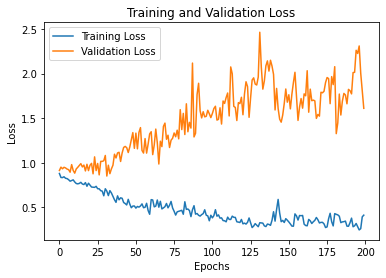

In [33]:
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
# Add labels, title, and legend
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

#### c-index

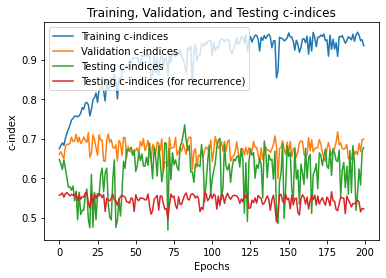

In [34]:
plt.plot(train_c_indices, label='Training c-indices')
plt.plot(val_c_indices, label='Validation c-indices')
plt.plot(test_c_indices, label='Testing c-indices')
plt.plot(test_c_indices_recurrence, label='Testing c-indices (for recurrence)')
# Add labels, title, and legend
plt.xlabel('Epochs')
plt.ylabel('c-index')
plt.title('Training, Validation, and Testing c-indices')
plt.legend()
plt.show()

# Get the node information of last hidden layer

#### Load trained model

In [40]:
best_state_dict = torch.load('/dartfs/rc/nosnapshots/V/VaickusL-nb/EDIT_Interns_2023/user/JiQing/TCGA_model/DNAm/Model_Saving/self_normalising_neural_networks_No_Dropout_with_AgeSexStage_MethyPhenoInteraction_CoxSelectedCpGs/model_best.pth')

#### Load predicted model

In [41]:
model_pred= DNAm_Pred(input_size, hidden_sizes, output_size).to(device)
model_pred.load_state_dict(best_state_dict)

<All keys matched successfully>

In [42]:
data_loader_test2 = DataLoader(DH_DNAm_Data, batch_size=len(DH_DNAm_Data), shuffle=False)
model_pred.eval()
model_pred.train(False)
with torch.no_grad():
    for idx,data in enumerate(data_loader_test2):
        censors = data[3]
        times = data[2]
        data1 = data[0].float().to(device)
        data2 = data[1].float().to(device)
        if torch.any(censors.isnan()):
            censors = torch.nan_to_num(censors)
        if torch.any(times.isnan()):
            times = torch.nan_to_num(times)
        if torch.any(data1.isnan()):
            data1 = torch.nan_to_num(data1)
        if torch.any(data2.isnan()):
            data2 = torch.nan_to_num(data2)
        z_pred = model_pred(data1, data2)

In [43]:
z_pred_df = pd.DataFrame(z_pred.detach().cpu().numpy())
z_pred_df

,0,1,2,3,4,5,6,7,8,9,...,22,23,24,25,26,27,28,29,30,31
0,-0.227652,0.453645,0.234181,0.021177,-0.267791,-0.120930,0.398962,0.327468,0.344710,1.045610,...,0.257378,0.152512,0.056385,0.526528,0.251258,0.670899,-0.421195,0.639386,-0.182035,-0.120778
1,-0.849573,1.296105,0.912619,-1.390604,0.537967,-0.545471,1.524071,-1.110044,-0.589697,2.633887,...,-0.958992,1.174022,-1.151287,1.418877,-0.745458,2.337399,-1.736515,2.485053,-0.644057,-1.488263
2,-0.284059,0.539887,0.309596,-0.118252,-0.213270,-0.172523,0.561862,0.153221,0.280807,1.239182,...,0.091710,0.278614,-0.077740,0.631412,0.149365,0.844082,-0.597452,0.856777,-0.237190,-0.245589
3,-0.271815,0.466653,0.278799,-0.064546,-0.167162,-0.146168,0.443109,0.173568,0.182336,1.077609,...,0.044848,0.242688,-0.094148,0.528585,0.113816,0.778656,-0.429908,0.734564,-0.206433,-0.264809
4,-0.176724,0.389075,0.192332,0.078896,-0.301890,-0.097026,0.357086,0.320794,0.354293,0.894354,...,0.220540,0.116591,0.072239,0.433885,0.222615,0.544137,-0.309701,0.529573,-0.150426,-0.062986
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
83,-0.162820,0.306400,0.153313,0.092608,-0.298403,-0.075562,0.254128,0.327953,0.315412,0.754572,...,0.179888,0.083520,0.047899,0.390252,0.244972,0.477011,-0.221405,0.432861,-0.126626,-0.038645
84,-0.291832,0.484767,0.316434,-0.268550,-0.049408,-0.182331,0.562221,-0.069361,0.040775,1.094693,...,-0.098367,0.329852,-0.257445,0.564435,-0.034791,0.874897,-0.558545,0.853041,-0.230744,-0.381518
85,-0.276133,0.533645,0.310097,-0.163992,-0.186651,-0.170105,0.521009,0.100943,0.233609,1.180907,...,0.042774,0.264489,-0.128073,0.598672,0.086733,0.823947,-0.576390,0.861031,-0.228213,-0.263714
86,0.727476,-0.934155,-0.828878,2.055358,-1.368847,0.521824,-1.348017,2.098351,1.519311,-1.532157,...,1.841873,-1.273068,1.835419,-0.945009,1.650317,-1.957321,1.746640,-2.265947,0.536119,1.776992


In [45]:
z_pred_df['FFPE.DNA.ID'] = DNAm_DH['FFPE.DNA.ID']
z_pred_df['Blood.Sample.ID'] = DNAm_DH['Blood.Sample.ID']
z_pred_df['ChIP_ID_Blood'] = DNAm_DH['ChIP_ID_Blood']
z_pred_df

,0,1,2,3,4,5,6,7,8,9,...,25,26,27,28,29,30,31,FFPE.DNA.ID,Blood.Sample.ID,ChIP_ID_Blood
0,-0.227652,0.453645,0.234181,0.021177,-0.267791,-0.120930,0.398962,0.327468,0.344710,1.045610,...,0.526528,0.251258,0.670899,-0.421195,0.639386,-0.182035,-0.120778,BLD050,A00000FBK,203723190040_R08C01
1,-0.849573,1.296105,0.912619,-1.390604,0.537967,-0.545471,1.524071,-1.110044,-0.589697,2.633887,...,1.418877,-0.745458,2.337399,-1.736515,2.485053,-0.644057,-1.488263,BLD043,A00000FC3,203752100070_R04C01
2,-0.284059,0.539887,0.309596,-0.118252,-0.213270,-0.172523,0.561862,0.153221,0.280807,1.239182,...,0.631412,0.149365,0.844082,-0.597452,0.856777,-0.237190,-0.245589,BLD061,A00000EH7,203789410029_R03C01
3,-0.271815,0.466653,0.278799,-0.064546,-0.167162,-0.146168,0.443109,0.173568,0.182336,1.077609,...,0.528585,0.113816,0.778656,-0.429908,0.734564,-0.206433,-0.264809,BLD046,A00000FBS,203734290015_R06C01
4,-0.176724,0.389075,0.192332,0.078896,-0.301890,-0.097026,0.357086,0.320794,0.354293,0.894354,...,0.433885,0.222615,0.544137,-0.309701,0.529573,-0.150426,-0.062986,BLD080,A00000ECL,203751390067_R03C01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
83,-0.162820,0.306400,0.153313,0.092608,-0.298403,-0.075562,0.254128,0.327953,0.315412,0.754572,...,0.390252,0.244972,0.477011,-0.221405,0.432861,-0.126626,-0.038645,BLD048,BDB1P03023,202163530099_R07C01
84,-0.291832,0.484767,0.316434,-0.268550,-0.049408,-0.182331,0.562221,-0.069361,0.040775,1.094693,...,0.564435,-0.034791,0.874897,-0.558545,0.853041,-0.230744,-0.381518,BLD075,BDB1P04022,202172220150_R06C01
85,-0.276133,0.533645,0.310097,-0.163992,-0.186651,-0.170105,0.521009,0.100943,0.233609,1.180907,...,0.598672,0.086733,0.823947,-0.576390,0.861031,-0.228213,-0.263714,BLD024,BDB1P02094,202163530080_R06C01
86,0.727476,-0.934155,-0.828878,2.055358,-1.368847,0.521824,-1.348017,2.098351,1.519311,-1.532157,...,-0.945009,1.650317,-1.957321,1.746640,-2.265947,0.536119,1.776992,BLD094,BDB1P03058,202163550181_R02C01


In [46]:
z_pred_df.to_csv("z_pred_test_SelfNormalizingNetworks_NoDropout_with_AgeSexStage_MethyPhenoInteraction_CoxSelectedCpGs.csv")

In [47]:
z_pred_df = pd.read_csv("/dartfs/rc/nosnapshots/V/VaickusL-nb/EDIT_Interns_2023/user/JiQing/TCGA_model/DNAm/z_pred_test_SelfNormalizingNetworks_NoDropout_with_AgeSexStage_MethyPhenoInteraction_CoxSelectedCpGs.csv",index_col=0)
z_pred_df

,0,1,2,3,4,5,6,7,8,9,...,25,26,27,28,29,30,31,FFPE.DNA.ID,Blood.Sample.ID,ChIP_ID_Blood
0,-0.227652,0.453645,0.234181,0.021177,-0.267791,-0.120930,0.398962,0.327468,0.344710,1.045610,...,0.526528,0.251258,0.670899,-0.421195,0.639386,-0.182035,-0.120778,BLD050,A00000FBK,203723190040_R08C01
1,-0.849573,1.296105,0.912620,-1.390604,0.537967,-0.545471,1.524071,-1.110044,-0.589697,2.633887,...,1.418877,-0.745458,2.337398,-1.736515,2.485053,-0.644057,-1.488263,BLD043,A00000FC3,203752100070_R04C01
2,-0.284059,0.539887,0.309596,-0.118252,-0.213270,-0.172523,0.561862,0.153221,0.280807,1.239182,...,0.631412,0.149365,0.844082,-0.597452,0.856777,-0.237190,-0.245589,BLD061,A00000EH7,203789410029_R03C01
3,-0.271815,0.466653,0.278799,-0.064546,-0.167162,-0.146168,0.443109,0.173568,0.182336,1.077609,...,0.528585,0.113816,0.778656,-0.429908,0.734564,-0.206433,-0.264809,BLD046,A00000FBS,203734290015_R06C01
4,-0.176724,0.389075,0.192332,0.078896,-0.301890,-0.097026,0.357086,0.320794,0.354293,0.894354,...,0.433885,0.222615,0.544137,-0.309701,0.529573,-0.150426,-0.062986,BLD080,A00000ECL,203751390067_R03C01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
83,-0.162820,0.306400,0.153313,0.092608,-0.298403,-0.075562,0.254128,0.327953,0.315412,0.754572,...,0.390252,0.244972,0.477011,-0.221405,0.432861,-0.126626,-0.038645,BLD048,BDB1P03023,202163530099_R07C01
84,-0.291832,0.484767,0.316434,-0.268550,-0.049408,-0.182331,0.562221,-0.069361,0.040775,1.094693,...,0.564435,-0.034791,0.874897,-0.558545,0.853041,-0.230744,-0.381518,BLD075,BDB1P04022,202172220150_R06C01
85,-0.276133,0.533645,0.310098,-0.163992,-0.186651,-0.170105,0.521009,0.100943,0.233609,1.180907,...,0.598672,0.086733,0.823947,-0.576390,0.861031,-0.228213,-0.263714,BLD024,BDB1P02094,202163530080_R06C01
86,0.727476,-0.934155,-0.828878,2.055358,-1.368847,0.521824,-1.348017,2.098351,1.519311,-1.532157,...,-0.945009,1.650317,-1.957321,1.746640,-2.265947,0.536119,1.776992,BLD094,BDB1P03058,202163550181_R02C01


# Get the predicted hazard of testing set

##### Build prediction model

In [31]:
input_size = len(TCGA_DNAm_Data.__getitem__(2)[0])*len(TCGA_DNAm_Data.__getitem__(2)[1])
hidden_sizes = [512, 256, 128, 64, 32]
output_size = 1
prediction_model = DNAm_MLP(input_size, hidden_sizes, output_size).to(device)

##### Load trained model

In [32]:
best_state_dict = torch.load('/dartfs/rc/nosnapshots/V/VaickusL-nb/EDIT_Interns_2023/user/JiQing/TCGA_model/DNAm/Model_Saving/self_normalising_neural_networks_No_Dropout_with_AgeStandSexStage_MethyPhenoInteraction_CoxSelectedCpGs/model_best.pth')
best_state_dict

OrderedDict([('input_layer.weight',
              tensor([[-1.2237e-02,  1.8509e-02, -1.3463e-03,  ..., -6.9043e-03,
                        6.2724e-03, -2.0016e-03],
                      [-2.1274e-02,  7.8136e-03,  5.0463e-04,  ..., -7.1853e-03,
                        5.8833e-04,  1.7078e-03],
                      [-1.4273e-03, -1.8128e-03, -2.5361e-05,  ...,  9.5532e-04,
                       -1.6643e-03,  1.1436e-03],
                      ...,
                      [-2.9441e-03, -1.9795e-02, -1.0337e-03,  ..., -1.8619e-03,
                       -1.9366e-02,  6.2859e-04],
                      [-1.2955e-02, -1.1432e-02, -8.0653e-04,  ..., -3.8350e-03,
                        4.8401e-03, -1.8675e-03],
                      [ 6.7060e-03, -2.4896e-03, -8.6429e-05,  ...,  6.6217e-03,
                        6.5142e-03, -4.6955e-04]], device='cuda:3')),
             ('input_layer.bias',
              tensor([ 2.1097e-03,  9.5755e-03, -7.9015e-05, -6.0903e-04, -1.8484e-02,
          

In [33]:
prediction_model.load_state_dict(best_state_dict)

<All keys matched successfully>

### Get hazards

In [34]:
hazards = []
prediction_model.eval()
prediction_model.train(False)
with torch.no_grad():
    for idx,data in enumerate(data_loader_test):
        censors = data[3]
        times = data[2]
        data1 = data[0].float().to(device)
        data2 = data[1].float().to(device)
        if torch.any(censors.isnan()):
            censors = torch.nan_to_num(censors)
        if torch.any(times.isnan()):
            times = torch.nan_to_num(times)
        if torch.any(data1.isnan()):
            data1 = torch.nan_to_num(data1)
        if torch.any(data2.isnan()):
            data2 = torch.nan_to_num(data2)        
        hazard_pred = prediction_model(data1, data2)
        
        hazards_pred = hazard_pred.cpu().numpy()
        
        data1.detach()
        data2.detach()
        
        for i in hazards_pred:
            hazards.append(i.item())

### Merge to the original data frame

In [37]:
predicted_df = DNAm_DH[['FFPE.DNA.ID','Blood.Sample.ID','death_stat','death_censor_time','TenDead','TenYearSurv','RFS_stat','RFS_censor_time','TenRFS','TenYearRFS','Sex','Age']].copy()
predicted_hazards = hazards
predicted_df['predicted_hazard_DNAm'] = predicted_hazards
predicted_df

,FFPE.DNA.ID,Blood.Sample.ID,death_stat,death_censor_time,TenDead,TenYearSurv,RFS_stat,RFS_censor_time,TenRFS,TenYearRFS,Sex,Age,predicted_hazard_DNAm
0,BLD050,A00000FBK,1,3816.344970,0,3600.000000,1,3816.344970,0,3600.000000,male,77,-3.568582
1,BLD043,A00000FC3,1,4869.979467,0,3600.000000,1,4869.979467,0,3600.000000,female,77,-4.798215
2,BLD061,A00000EH7,0,3780.000000,0,3600.000000,0,3780.000000,0,3600.000000,female,76,-4.305058
3,BLD046,A00000FBS,1,2991.375770,1,2991.375770,1,2991.375770,1,2991.375770,male,69,1.246596
4,BLD080,A00000ECL,1,1392.689939,1,1392.689939,1,1392.689939,1,1392.689939,male,66,-4.403623
...,...,...,...,...,...,...,...,...,...,...,...,...,...
83,BLD048,BDB1P03023,1,3609.363450,0,3600.000000,1,3609.363450,0,3600.000000,male,58,-3.892819
84,BLD075,BDB1P04022,0,4230.000000,0,3600.000000,0,4230.000000,0,3600.000000,male,51,-5.044590
85,BLD024,BDB1P02094,0,4500.000000,0,3600.000000,0,4500.000000,0,3600.000000,male,68,-4.274013
86,BLD094,BDB1P03058,0,4410.000000,0,3600.000000,1,1999.232877,1,1999.232877,male,53,-5.556091


### Save

In [38]:
predicted_df.to_csv('/dartfs/rc/nosnapshots/V/VaickusL-nb/EDIT_Interns_2023/user/JiQing/TCGA_model/DNAm/predicted_hazards_DNAm.csv')